Necessary Imports

In [2]:
import os
import sys
import pandas as pd
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

sys.path.append(os.path.abspath(os.path.join('..', '..', 'models', 'cnn')))
from cnn import CNN
from multilabel_cnn import MultiLabelCNN


Implement a function load mnist data() that extracts images from the
dataset folders and organizes them into separate lists for images and labels
corresponding to the train, validation, and test splits. Ensure that the
images are loaded from their respective folders without any overlap or
mixing.

In [ ]:
def load_mnist_data(base_path='../../data/external/double_mnist', use_label_count=False):
    images = {
        'train': [],
        'val': [],
        'test': []
    }
    labels = {
        'train': [],
        'val': [],
        'test': []
    }

    splits = ['train', 'val', 'test']
    for split in splits:
        split_path = os.path.join(base_path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_name)
                    img = Image.open(img_path).convert('L')
                    img_array = np.array(img)
                    images[split].append(img_array)

                    if use_label_count:
                        if label == "0":
                            label_count = 0
                        else:
                            label_count = len(label)
                        labels[split].append(label_count)
                    else:
                        labels[split].append(one_hot_encode_label(label))

    return images, labels

images, labels = load_mnist_data(use_label_count=True)


Create a class called MultiMNISTDataset that will be used to create
dataloaders for training and evaluation purposes.

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        img = torch.tensor(img, dtype=torch.float32) / 255.0  

        if self.transform:
            img = self.transform(img)

        return img, label

transform = transforms.Compose([
    transforms.ToPILImage(),         
    transforms.Resize((28, 28)),     
    transforms.ToTensor(),         
])

train_dataset = MultiMNISTDataset(images['train'], labels['train'], transform=transform)
val_dataset = MultiMNISTDataset(images['val'], labels['val'], transform=transform)
test_dataset = MultiMNISTDataset(images['test'], labels['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Implement the CNN Class

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(task='regression', num_classes=4, num_conv_layers=3,dropout_rate=0.2, optimizer_choice='adam', device=device).to(device)
model.fit(train_loader, val_loader, epochs=5, lr=0.001)

./figures/cnn_loss_plots/plot.png


Training Epoch 1/5: 100%|██████████| 394/394 [00:19<00:00, 20.32it/s]


Epoch [1/5], Training Loss: 0.1568, Validation Loss: 0.0153


Training Epoch 2/5: 100%|██████████| 394/394 [00:18<00:00, 20.87it/s]


Epoch [2/5], Training Loss: 0.0324, Validation Loss: 0.0098


Training Epoch 3/5: 100%|██████████| 394/394 [00:19<00:00, 20.49it/s]


Epoch [3/5], Training Loss: 0.0285, Validation Loss: 0.0080


Training Epoch 4/5: 100%|██████████| 394/394 [00:19<00:00, 20.30it/s]


Epoch [4/5], Training Loss: 0.0264, Validation Loss: 0.0156


Training Epoch 5/5: 100%|██████████| 394/394 [00:19<00:00, 20.54it/s]


Epoch [5/5], Training Loss: 0.0263, Validation Loss: 0.0052


In [7]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, test_loader, output_file='predictions.csv'):
    model.eval()
    predictions = model.predict(test_loader)
    
    true_labels = []
    for _, labels in test_loader:
        true_labels.append(labels)
    true_labels = torch.cat(true_labels).cpu()
    predictions = torch.round(predictions).cpu()
    
    # Create a DataFrame to display true labels, predictions, and correctness
    results_df = pd.DataFrame({
        'True Labels': true_labels.numpy(),
        'Predictions': predictions.numpy(),
        'Correctness': ['✓' if true == pred else 'x' for true, pred in zip(true_labels.numpy(), predictions.numpy())]
    })
    
    print(results_df.head())
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
    
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

accuracy = calculate_accuracy(model, test_loader)


   True Labels  Predictions Correctness
0            3          3.0           ✓
1            3          3.0           ✓
2            3          3.0           ✓
3            3          3.0           ✓
4            3          3.0           ✓
Results saved to predictions.csv
Test Accuracy: 1.0000


In [ ]:
import os
import json
import torch.nn as nn
import torch

hyperparam_combinations = [
    {'lr': 0.001, 'dropout_rate': 0.3, 'num_conv_layers': 2, 'optimizer_choice': 'adam'},
    {'lr': 0.001, 'dropout_rate': 0.5, 'num_conv_layers': 3, 'optimizer_choice': 'adam'},
    {'lr': 0.0005, 'dropout_rate': 0.5, 'num_conv_layers': 2, 'optimizer_choice': 'sgd'},
    {'lr': 0.0005, 'dropout_rate': 0.3, 'num_conv_layers': 3, 'optimizer_choice': 'sgd'},
    {'lr': 0.0001, 'dropout_rate': 0.5, 'num_conv_layers': 4, 'optimizer_choice': 'adam'}
]

plot_save_dir = "./figures/cnn_loss_plots"
os.makedirs(plot_save_dir, exist_ok=True)

best_classification_model, best_classification_loss, best_classification_combination = None, float('inf'), None
best_regression_model, best_regression_loss, best_regression_combination = None, float('inf'), None

for task in ['classification', 'regression']:
    for idx, params in enumerate(hyperparam_combinations, 1):
        loss_figure_save_path = os.path.join(
            plot_save_dir,
            f"{task}_loss_combination_{idx}_lr_{params['lr']}_dropout_{params['dropout_rate']}_layers_{params['num_conv_layers']}_opt_{params['optimizer_choice']}.png"
        )
        model = CNN(
            task=task,
            num_classes=4 if task == 'classification' else 1,
            num_conv_layers=params['num_conv_layers'],
            dropout_rate=params['dropout_rate'],
            optimizer_choice=params['optimizer_choice'],
            device='cuda' if torch.cuda.is_available() else 'cpu',
            loss_figure_save_path = loss_figure_save_path
        )

        model.fit(train_loader, val_loader, epochs=2, lr=params['lr'])
        
        criterion = nn.CrossEntropyLoss() if task == 'classification' else nn.MSELoss()
        val_loss = model.evaluate(val_loader, criterion=criterion)
        
        if task == 'classification':
            if val_loss < best_classification_loss:
                best_classification_model = model
                best_classification_loss = val_loss
                best_classification_combination = params
        else:  # task == 'regression'
            if val_loss < best_regression_loss:
                best_regression_model = model
                best_regression_loss = val_loss
                best_regression_combination = params

best_params = {
    "best_classification_combination": best_classification_combination,
    "best_regression_combination": best_regression_combination
}

params_file_path = os.path.join(plot_save_dir, "best_model_params.json")
with open(params_file_path, 'w') as json_file:
    json.dump(best_params, json_file, indent=4)

print("Best Classification Model Combination:", best_classification_combination)
print("Best Regression Model Combination:", best_regression_combination)
print(f"Best parameters saved to {params_file_path}")

./figures/cnn_loss_plots/classification_loss_combination_1_lr_0.001_dropout_0.3_layers_2_opt_adam.png


Training Epoch 1/2: 100%|██████████| 394/394 [00:14<00:00, 27.04it/s]


Epoch [1/2], Training Loss: 0.2117, Validation Loss: 0.0053


Training Epoch 2/2: 100%|██████████| 394/394 [00:14<00:00, 26.96it/s]


Epoch [2/2], Training Loss: 0.0083, Validation Loss: 0.0032
./figures/cnn_loss_plots/classification_loss_combination_2_lr_0.001_dropout_0.5_layers_3_opt_adam.png


Training Epoch 1/2: 100%|██████████| 394/394 [00:16<00:00, 23.78it/s]


Epoch [1/2], Training Loss: 0.2935, Validation Loss: 0.0028


Training Epoch 2/2: 100%|██████████| 394/394 [00:12<00:00, 32.34it/s]


Epoch [2/2], Training Loss: 0.0105, Validation Loss: 0.0071
./figures/cnn_loss_plots/classification_loss_combination_3_lr_0.0005_dropout_0.5_layers_2_opt_sgd.png


Training Epoch 1/2: 100%|██████████| 394/394 [00:09<00:00, 41.03it/s]


Epoch [1/2], Training Loss: 1.1696, Validation Loss: 1.0771


Training Epoch 2/2: 100%|██████████| 394/394 [00:09<00:00, 41.76it/s]


Epoch [2/2], Training Loss: 1.1167, Validation Loss: 1.0460
./figures/cnn_loss_plots/classification_loss_combination_4_lr_0.0005_dropout_0.3_layers_3_opt_sgd.png


Training Epoch 1/2: 100%|██████████| 394/394 [00:11<00:00, 35.47it/s]


Epoch [1/2], Training Loss: 1.2357, Validation Loss: 1.0965


Training Epoch 2/2: 100%|██████████| 394/394 [00:11<00:00, 33.76it/s]


Epoch [2/2], Training Loss: 1.1357, Validation Loss: 1.0845
./figures/cnn_loss_plots/classification_loss_combination_5_lr_0.0001_dropout_0.5_layers_4_opt_adam.png


Training Epoch 1/2: 100%|██████████| 394/394 [00:13<00:00, 28.49it/s]


Epoch [1/2], Training Loss: 0.7668, Validation Loss: 0.0730


Training Epoch 2/2: 100%|██████████| 394/394 [00:13<00:00, 29.55it/s]


Epoch [2/2], Training Loss: 0.0397, Validation Loss: 0.0144
./figures/cnn_loss_plots/regression_loss_combination_1_lr_0.001_dropout_0.3_layers_2_opt_adam.png


Training Epoch 1/2: 100%|██████████| 394/394 [00:11<00:00, 34.52it/s]


Epoch [1/2], Training Loss: 0.1814, Validation Loss: 0.0304


Training Epoch 2/2: 100%|██████████| 394/394 [00:11<00:00, 34.78it/s]


Epoch [2/2], Training Loss: 0.0627, Validation Loss: 0.0196
./figures/cnn_loss_plots/regression_loss_combination_2_lr_0.001_dropout_0.5_layers_3_opt_adam.png


Training Epoch 1/2: 100%|██████████| 394/394 [00:13<00:00, 29.41it/s]


Epoch [1/2], Training Loss: 0.2237, Validation Loss: 0.0644


Training Epoch 2/2: 100%|██████████| 394/394 [00:12<00:00, 31.35it/s]


Epoch [2/2], Training Loss: 0.0965, Validation Loss: 0.1127
./figures/cnn_loss_plots/regression_loss_combination_3_lr_0.0005_dropout_0.5_layers_2_opt_sgd.png


Training Epoch 1/2: 100%|██████████| 394/394 [00:11<00:00, 34.86it/s]


Epoch [1/2], Training Loss: 0.6034, Validation Loss: 0.2043


Training Epoch 2/2: 100%|██████████| 394/394 [00:11<00:00, 35.11it/s]


Epoch [2/2], Training Loss: 0.2040, Validation Loss: 0.1193
./figures/cnn_loss_plots/regression_loss_combination_4_lr_0.0005_dropout_0.3_layers_3_opt_sgd.png


Training Epoch 1/2: 100%|██████████| 394/394 [00:12<00:00, 30.94it/s]


Epoch [1/2], Training Loss: 0.7498, Validation Loss: 0.2468


Training Epoch 2/2: 100%|██████████| 394/394 [00:12<00:00, 31.31it/s]


Epoch [2/2], Training Loss: 0.2516, Validation Loss: 0.1488
./figures/cnn_loss_plots/regression_loss_combination_5_lr_0.0001_dropout_0.5_layers_4_opt_adam.png


Training Epoch 1/2: 100%|██████████| 394/394 [00:12<00:00, 31.58it/s]


Epoch [1/2], Training Loss: 0.6441, Validation Loss: 0.1403


Training Epoch 2/2: 100%|██████████| 394/394 [00:12<00:00, 30.79it/s]


Epoch [2/2], Training Loss: 0.1625, Validation Loss: 0.0365
Best Classification Model Combination: {'lr': 0.001, 'dropout_rate': 0.3, 'num_conv_layers': 2, 'optimizer_choice': 'adam'}
Best Regression Model Combination: {'lr': 0.001, 'dropout_rate': 0.3, 'num_conv_layers': 2, 'optimizer_choice': 'adam'}
Best parameters saved to ./figures/cnn_loss_plots/best_model_params.json


In [ ]:
def read_best_params(file_path):
    with open(file_path, 'r') as json_file:
        params = json.load(json_file)
    return params

loaded_params = read_best_params(params_file_path)
print("Loaded Parameters:", loaded_params)


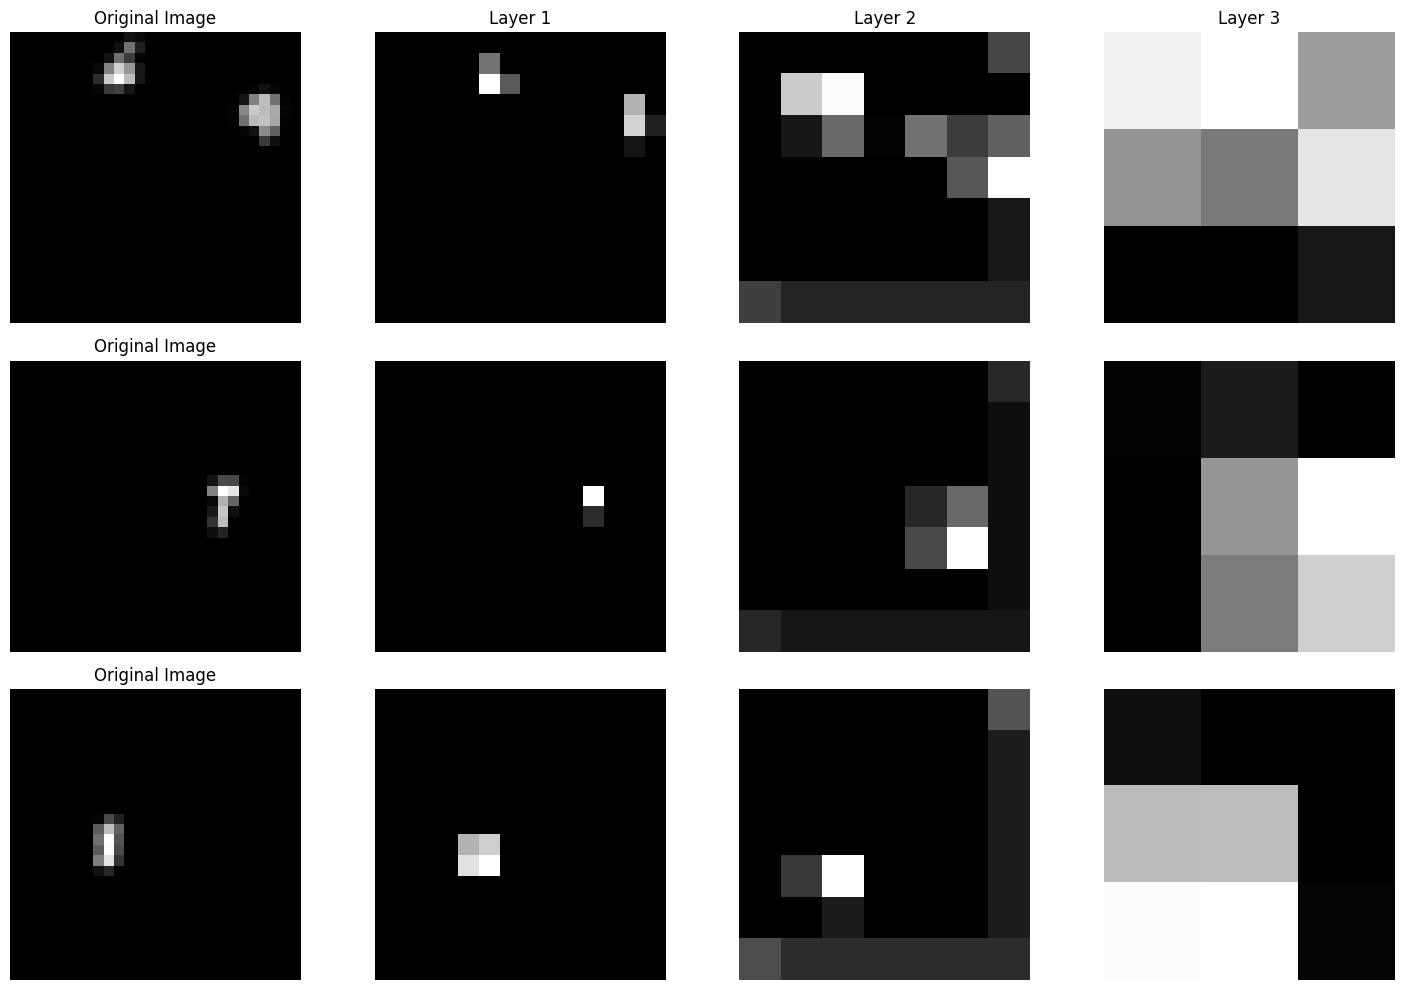

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_feature_maps(model, data_loader, feature_map_index=0, num_images=3):
    model.eval()  # Set the model to evaluation mode

    # Get a batch of images
    images, _ = next(iter(data_loader))

    # Move images to the appropriate device (CPU or GPU)
    images = images.to(model.device)

    # Forward pass to get feature maps
    with torch.no_grad():
        _, feature_maps = model(images, return_feature_maps=True)

    # Select the first three images and their feature maps
    selected_images = images[:num_images]
    selected_maps = [feature_maps[i][:num_images] for i in range(len(feature_maps))]

    # Set up the plot
    fig, axes = plt.subplots(num_images, len(selected_maps) + 1, figsize=(15, 10))

    for i in range(num_images):
        # Plot original image
        axes[i, 0].imshow(selected_images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Plot feature maps
        for j in range(len(selected_maps)):
            axes[i, j + 1].imshow(selected_maps[j][i, feature_map_index].cpu().numpy(), cmap='gray')
            axes[i, j + 1].axis('off')
            if i == 0:
                axes[i, j + 1].set_title(f'Layer {j + 1}')

    plt.tight_layout()
    plt.show()

# Usage
visualize_feature_maps(model, train_loader, feature_map_index=2)


In [40]:
def one_hot_encode_digit(digit):
    """Creates an 11-dimensional one-hot vector for a single digit or blank."""
    one_hot = np.zeros(11)
    if digit == '*':
        one_hot[10] = 1 
    else:
        one_hot[int(digit)] = 1
    return one_hot

def one_hot_encode_label(label):
    """Encodes the label (up to three digits) as a 33-dimensional vector."""
    label_str = str(label).ljust(3, '*')
    one_hot_encoded = np.concatenate([one_hot_encode_digit(digit) for digit in label_str])
    return one_hot_encoded

In [41]:
images, labels = load_mnist_data(use_label_count=False)

train_dataset = MultiMNISTDataset(images['train'], labels['train'], transform=transform)
val_dataset = MultiMNISTDataset(images['val'], labels['val'], transform=transform)
test_dataset = MultiMNISTDataset(images['test'], labels['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiLabelCNN(device=device).to(device)
model.fit(train_loader, val_loader, epochs=30, lr=0.001)

Training Epoch 1/30: 100%|██████████| 394/394 [00:09<00:00, 39.86it/s]


Epoch [1/30], Training Loss: 4.9888
Epoch [1/30], Validation Loss: 5.4152


Training Epoch 2/30: 100%|██████████| 394/394 [00:09<00:00, 40.76it/s]


Epoch [2/30], Training Loss: 4.1246
Epoch [2/30], Validation Loss: 4.9924


Training Epoch 3/30: 100%|██████████| 394/394 [00:09<00:00, 42.74it/s]


Epoch [3/30], Training Loss: 3.7269
Epoch [3/30], Validation Loss: 4.8242


Training Epoch 4/30: 100%|██████████| 394/394 [00:09<00:00, 42.82it/s]


Epoch [4/30], Training Loss: 3.4545
Epoch [4/30], Validation Loss: 4.8486


Training Epoch 5/30: 100%|██████████| 394/394 [00:09<00:00, 40.18it/s]


Epoch [5/30], Training Loss: 3.2462
Epoch [5/30], Validation Loss: 4.8175


Training Epoch 6/30: 100%|██████████| 394/394 [00:09<00:00, 42.04it/s]


Epoch [6/30], Training Loss: 3.0984
Epoch [6/30], Validation Loss: 5.5019


Training Epoch 7/30: 100%|██████████| 394/394 [00:09<00:00, 40.50it/s]


Epoch [7/30], Training Loss: 2.9926
Epoch [7/30], Validation Loss: 4.8026


Training Epoch 8/30: 100%|██████████| 394/394 [00:11<00:00, 33.67it/s]


Epoch [8/30], Training Loss: 2.9086
Epoch [8/30], Validation Loss: 4.8351


Training Epoch 9/30: 100%|██████████| 394/394 [00:08<00:00, 44.17it/s]


Epoch [9/30], Training Loss: 2.7775
Epoch [9/30], Validation Loss: 4.5205


Training Epoch 10/30: 100%|██████████| 394/394 [00:10<00:00, 39.02it/s]


Epoch [10/30], Training Loss: 2.6349
Epoch [10/30], Validation Loss: 4.3639


Training Epoch 11/30: 100%|██████████| 394/394 [00:09<00:00, 40.17it/s]


Epoch [11/30], Training Loss: 2.4956
Epoch [11/30], Validation Loss: 4.0491


Training Epoch 12/30: 100%|██████████| 394/394 [00:10<00:00, 37.77it/s]


Epoch [12/30], Training Loss: 2.3204
Epoch [12/30], Validation Loss: 4.4107


Training Epoch 13/30: 100%|██████████| 394/394 [00:11<00:00, 35.15it/s]


Epoch [13/30], Training Loss: 2.1231
Epoch [13/30], Validation Loss: 4.3811


Training Epoch 14/30: 100%|██████████| 394/394 [00:10<00:00, 39.32it/s]


Epoch [14/30], Training Loss: 1.9350
Epoch [14/30], Validation Loss: 3.8893


Training Epoch 15/30: 100%|██████████| 394/394 [00:12<00:00, 31.58it/s]


Epoch [15/30], Training Loss: 1.7835
Epoch [15/30], Validation Loss: 3.9149


Training Epoch 16/30: 100%|██████████| 394/394 [00:10<00:00, 36.38it/s]


Epoch [16/30], Training Loss: 1.6560
Epoch [16/30], Validation Loss: 3.8619


Training Epoch 17/30: 100%|██████████| 394/394 [00:11<00:00, 35.51it/s]


Epoch [17/30], Training Loss: 1.5060
Epoch [17/30], Validation Loss: 3.6423


Training Epoch 18/30: 100%|██████████| 394/394 [00:13<00:00, 29.58it/s]


Epoch [18/30], Training Loss: 1.4228
Epoch [18/30], Validation Loss: 3.4240


Training Epoch 19/30: 100%|██████████| 394/394 [00:11<00:00, 33.04it/s]


Epoch [19/30], Training Loss: 1.2953
Epoch [19/30], Validation Loss: 3.5635


Training Epoch 20/30: 100%|██████████| 394/394 [00:11<00:00, 35.50it/s]


Epoch [20/30], Training Loss: 1.2202
Epoch [20/30], Validation Loss: 3.6041


Training Epoch 21/30: 100%|██████████| 394/394 [00:13<00:00, 30.04it/s]


Epoch [21/30], Training Loss: 1.1289


In [ ]:
def exact_match_accuracy(preds, labels):
    """Calculates the exact match accuracy between predictions and labels."""
    return (preds == labels).all(dim=1).float().mean().item()

def hamming_accuracy(preds, labels):
    """Calculates the Hamming accuracy for multi-label predictions."""
    return (preds == labels).float().mean().item()


def evaluate_model(model, test_loader):
    preds = model.predict(test_loader)
    labels = torch.cat([labels for _, labels in test_loader])
    print(preds[12], labels[12])

    exact_acc = exact_match_accuracy(preds, labels)
    hamming_acc = hamming_accuracy(preds, labels)
    print(f"Exact Match Accuracy: {exact_acc * 100:.2f}%")
    print(f"Hamming Accuracy: {hamming_acc * 100:.2f}%")

evaluate_model(model, test_loader)


tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]) tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
Exact Match Accuracy: 2.43%
Hamming Accuracy: 89.70%
